In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!kaggle datasets download -d ramamet4/app-store-apple-data-set-10k-apps

Dataset URL: https://www.kaggle.com/datasets/ramamet4/app-store-apple-data-set-10k-apps
License(s): GPL-2.0
  0% 0.00/5.63M [00:00<?, ?B/s]
100% 5.63M/5.63M [00:00<00:00, 75.4MB/s]


In [4]:
!unzip app-store-apple-data-set-10k-apps.zip

Archive:  app-store-apple-data-set-10k-apps.zip
  inflating: AppleStore.csv          
  inflating: appleStore_description.csv  


In [6]:
data = pd.read_csv('AppleStore.csv')
data.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [9]:
num_cols = [
    'size_bytes',
    'price',
    'rating_count_tot',
    'rating_count_ver',
    'sup_devices.num',
    'ipadSc_urls.num',
    'lang.num',
    # Эта фича - не числовая, а порядковая, но мы все равно возьмем ее как числовую для удобства
    'cont_rating',
]

cat_cols = [
    'currency',
    'prime_genre'
]

target_col = 'user_rating'

cols = num_cols + cat_cols + [target_col]

In [10]:
data = data[cols]
# Возраст записан не в виде числа, исправим это, вырезав последний символ и скастовав к числу
data['cont_rating'] = data['cont_rating'].str.slice(0, -1).astype(int)
data.head()

,size_bytes,price,rating_count_tot,rating_count_ver,sup_devices.num,ipadSc_urls.num,lang.num,cont_rating,currency,prime_genre,user_rating
0,100788224,3.99,21292,26,38,5,10,4,USD,Games,4.0
1,158578688,0.00,161065,26,37,5,23,4,USD,Productivity,4.0
2,100524032,0.00,188583,2822,37,5,3,4,USD,Weather,3.5
3,128512000,0.00,262241,649,37,5,9,12,USD,Shopping,4.0
4,92774400,0.00,985920,5320,37,5,45,4,USD,Reference,4.5


In [11]:
data.isna().mean()

,0
size_bytes,0.0
price,0.0
rating_count_tot,0.0
rating_count_ver,0.0
sup_devices.num,0.0
ipadSc_urls.num,0.0
lang.num,0.0
cont_rating,0.0
currency,0.0
prime_genre,0.0


In [12]:
# Посмотрим на распределение категориальных фичей
for col in cat_cols:
    print(f"{col} DISTRIBUTION")
    print(data[col].value_counts())
    print()

currency DISTRIBUTION
currency
USD    7197
Name: count, dtype: int64

prime_genre DISTRIBUTION
prime_genre
Games                3862
Entertainment         535
Education             453
Photo & Video         349
Utilities             248
Health & Fitness      180
Productivity          178
Social Networking     167
Lifestyle             144
Music                 138
Shopping              122
Sports                114
Book                  112
Finance               104
Travel                 81
News                   75
Weather                72
Reference              64
Food & Drink           63
Business               57
Navigation             46
Medical                23
Catalogs               10
Name: count, dtype: int64



In [13]:
# Как мы видим, в колонке currency только одно значение, можно колонку убрать
data = data.drop(columns=['currency'])
cat_cols.remove('currency')

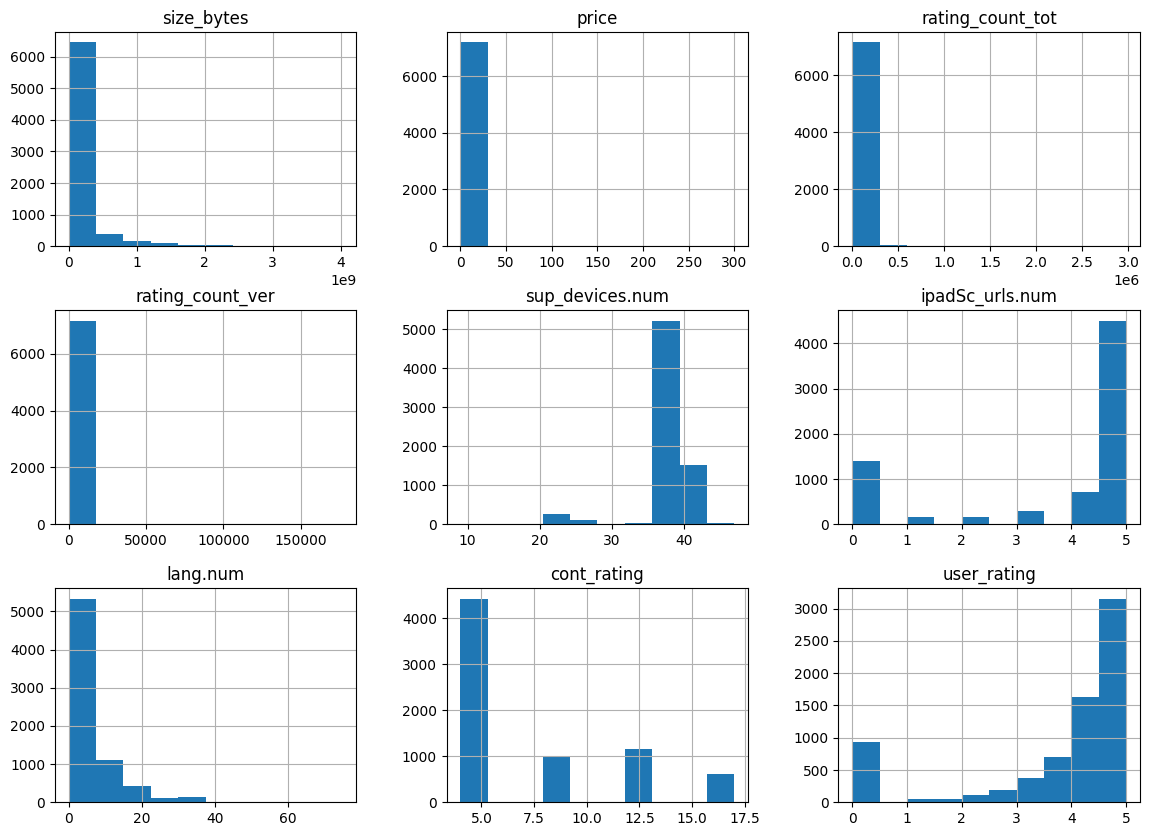

In [14]:
data.hist(column=num_cols+cat_cols+[target_col], figsize=(14, 10))
None

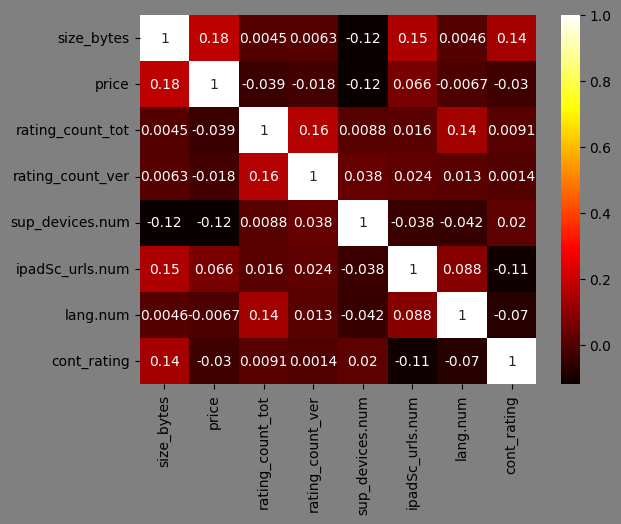

In [31]:
import seaborn as sns

matrix = data[num_cols].corr()

fig = plt.figure()
fig.patch.set_facecolor('gray')

sns.heatmap(matrix, cmap='hot', annot=True)
plt.show()

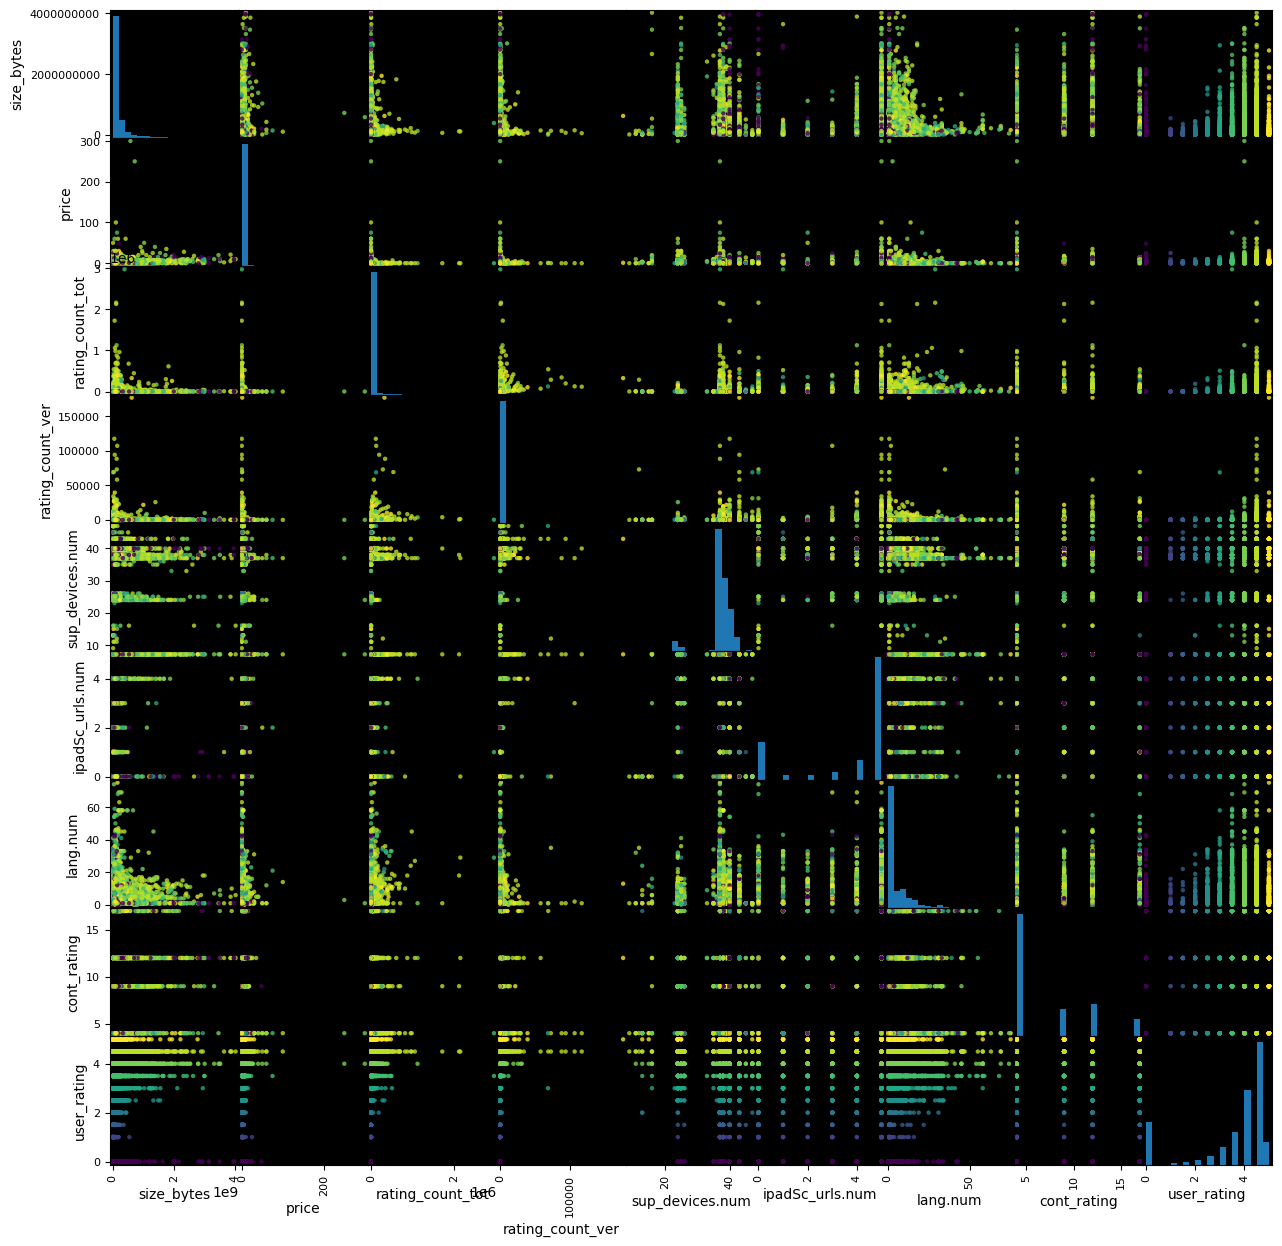

In [32]:
pd.plotting.scatter_matrix(data, c=data[target_col], figsize=(15, 15), marker='o',
                        hist_kwds={'bins': 20}, s=10, alpha=.8)
None

**Упражнение**: Мы только что посмотрели на данные, какой из просмотренных графиков говорит, что мы вряд ли сможем сделать хорошую модель?
> Ответ: Почти все, но по итогу крайний, так как по графикам корреляций у нас мало зависимых фичей и у некоторых она отсутствует вообще

### Создание фичей

Чем сложнее зависимость между фичей и таргетом, тем более сложная модель потребуется, чтобы эту зависимость использовать. Почему бы просто не выбрать семейство самых гибких моделей? Проблема в том, что без большого количества данных для обучения будет происходить overfit. Это значит, что модель выучит зависимости, которые случайно появились в обучающих из-за ограниченного размера выборки. Такая модель будет хорошо работать на обучающей выборке, но будет плохо справляться с реальной задачей.

Используя человеческие знания об устройстве мира, мы можем упростить такую зависимость, создав новые фичи. На самом деле, можно даже не использовать человеческие знания, а просто применить какой-нибудь алгоритм. Например, если у нас есть фичи $x_1, x_2, ..., x_n$, то мы можем добавить новые фичи вида
$$x_{newij} = x_i x_j, i \ne j$$
и понадеяться, что это улучшит предсказания

In [33]:
# Добавим категориальную фичу, которая говорит, бесплатное приложение или нет
data['is_free'] = data['price'] == 0
cat_cols.append('is_free')
data.head()

,size_bytes,price,rating_count_tot,rating_count_ver,sup_devices.num,ipadSc_urls.num,lang.num,cont_rating,prime_genre,user_rating,is_free
0,100788224,3.99,21292,26,38,5,10,4,Games,4.0,False
1,158578688,0.00,161065,26,37,5,23,4,Productivity,4.0,True
2,100524032,0.00,188583,2822,37,5,3,4,Weather,3.5,True
3,128512000,0.00,262241,649,37,5,9,12,Shopping,4.0,True
4,92774400,0.00,985920,5320,37,5,45,4,Reference,4.5,True


In [34]:
a = pd.DataFrame.from_dict({'categorical': ['a', 'b', 'a', 'c']})
a

,categorical
0,a
1,b
2,a
3,c


In [35]:
pd.get_dummies(a)

,categorical_a,categorical_b,categorical_c
0,True,False,False
1,False,True,False
2,True,False,False
3,False,False,True


In [36]:
data = pd.get_dummies(data, columns=cat_cols)

In [37]:
cat_cols_new = []
for col_name in cat_cols:
    cat_cols_new.extend(filter(lambda x: x.startswith(col_name), data.columns))
cat_cols = cat_cols_new

### Масштабирование признаков

Как мы говорили в лекции часто необходимо привести все признаки к одному масштабу. Для этого в sklearn есть специальный Transformer -- StandardScaler и MinMaxScaler.

StandardScaler во время .fit() для каждого признака $x_i$ считает среднее $\mu_i$ и стандартное отклонение $\sigma_i$ на обучающем датасете. Во время .transform() к каждому признаку применяется:

$$\mathbf{x_i}^{\text{new}} = \frac{\mathbf{x_i} - \mu_i}{\sigma_i}$$


MinMaxScaler во время .fit() для каждого признака $x_i$ считает минимум $x_{i, \text{min}}$ и максимум $x_{i, \text{max}}$ на обучающем датасете. Во время .transform() к каждому признаку применяется:

$$\mathbf{x_i}^{\text{new}} = \frac{\mathbf{x_i} - x_{i, \text{min}}}{x_{i, \text{max}} - x_{i, \text{min}}}$$

In [39]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit(data[num_cols + cat_cols])

X = std.transform(data[num_cols + cat_cols])

X = std.fit_transform(data[num_cols + cat_cols])

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, data[target_col], test_size=0.2)

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error

Поговорим про метрики. Метрика это, так же как и функция потерь, какая-то функция, показывающая насколько хорошо работает наша модель. Например, любой лосс можно назвать метрикой. Но не любую метрику можно назвать лоссом: лосс это именно то число, которое мы уменьшаем в процессе обучения модели + для лосса всегда верно, что чем он меньше, тем лучше. Метрики нужны как раз для того, чтобы оценивать работу алгоритма с помощью числа, которое он не учился напрямую минимизировать.

Для классификации наиболее простой метрикой будет являться точность или accuracy (доля совпавших предсказаний и настоящих классов). Она никогда не используется внутри лоссов, потому что нет эффективного алгоритма, который бы позволил ее обучать модели с такой функцией потерь.

В данном случае у нас задача регрессии, поэтому мы используем две метрики MSE и R_squared.

$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y^i - y_{pred}^i)^2}{\sum_{i=1}^{n} (y^i - y_{mean})^2}$$

R_aquared это доля объясненной вариации. R_squared = 1, когда у нас есть идеальный предсказатель. R_squared = 0 достигает модель, которая просто выдает в качестве ответа среднее Значение целевой переменной. А значения меньше 0 говорят о том, что модель хуже константного предсказателя.

In [43]:
def print_metrics(y_pred, y):
  print(f'R^2: {r2_score(y_pred, y)}')
  print(f'MSE: {mean_squared_error(y_pred, y)}')

In [51]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print_metrics(lr.predict(X_test), y_test)

R^2: -4.650250101471575
MSE: 1.970085820865553


In [52]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

print_metrics(knn.predict(X_test), y_test)

R^2: -1.09514733954392
MSE: 2.038076388888889


**Задание:** поиграйтесь с гиперпараметрами и улучшите предсказания моделей.

In [74]:
knn = KNeighborsRegressor(n_neighbors=13)
knn.fit(X_train, y_train)

print_metrics(knn.predict(X_test), y_test)

R^2: -1.6845938829010607
MSE: 1.845674104207758


## Cross Validation

До этого мы разбирали случай, когда выборка заранее делится на train/test, но часто данных итак не хватает и отдавать их часть на test слишком расточительно. В такой ситуации на помощью приходит кросс валидация:
1. Выберем $k$ - количество частей, на которые разобьется наш датасет
2. for $ i = 1..k$
    * Обучим модель на всех частях датасета, кроме i-ой.
    * Посчитаем метрики или предсказания для i-ой части
3. Саггрегируем все все предсказания или усредним метрики

Таким образом мы сможем получить более объективные предсказания нашей модели, использовав весь датасет как train и как test, при этом не создав утечек данных.

В sklearn существуют уже готовые классы моделей, которые за нас проводят все вышеописанные действия. Но у них есть один минус - выше мы уже писали, что лики могут произойти еще на этапе обработки данных. Избежать этого при ручной разбивке датасета легко, но в случае кросс валидации придется либо сдлеать специальный объект Pipeline, в котором будет скрыта вся обработка данных, и sklearn просто вызовет его $k$ раз, либо руками выбирать индексы объектов с помощью класса KFold и самостоятельно обрабатывать данные. Мы не будем делать ни то, ни другое, но покажем, как это может быть реализовано.

In [76]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

In [78]:
cross_validate(LinearRegression(), X, data[target_col], cv=5,
               scoring={'r2_score:': make_scorer(r2_score),
                        'mean_squared_error:': make_scorer(mean_squared_error)})

{'fit_time': array([0.06579113, 0.03010678, 0.0555439 , 0.03742957, 0.06056094]),
 'score_time': array([0.00748348, 0.01152921, 0.00301766, 0.01189017, 0.00609159]),
 'test_r2_score:': array([-0.83180594,  0.06616553,  0.11575665,  0.10998759,  0.07104445]),
 'test_mean_squared_error:': array([1.66689747, 1.48766359, 1.9403641 , 2.81734145, 2.93209146])}

In [79]:
cross_validate(KNeighborsRegressor(), X, data[target_col], cv=5,
               scoring={'r2_score': make_scorer(r2_score, ),
                        'mean_squared_error': make_scorer(mean_squared_error)})

{'fit_time': array([0.01398277, 0.0188992 , 0.00362611, 0.01395226, 0.00423479]),
 'score_time': array([0.40091443, 0.31261063, 0.21791244, 0.22282934, 0.13229108]),
 'test_r2_score': array([-0.59746466, -0.00837802,  0.0274914 ,  0.19082863,  0.0752518 ]),
 'test_mean_squared_error': array([1.45365278, 1.60641667, 2.13405142, 2.5614385 , 2.91881167])}

In [81]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(KNeighborsRegressor(),
                           [{'n_neighbors': [1, 2, 3, 4, 5, 6, 8, 10, 15]}],
                           cv=5,
                           error_score='raise',
                           verbose=10)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START n_neighbors=1...............................................
[CV 1/5; 1/9] END ...............n_neighbors=1;, score=-0.337 total time=   0.1s
[CV 2/5; 1/9] START n_neighbors=1...............................................
[CV 2/5; 1/9] END ...............n_neighbors=1;, score=-0.381 total time=   0.0s
[CV 3/5; 1/9] START n_neighbors=1...............................................
[CV 3/5; 1/9] END ...............n_neighbors=1;, score=-0.371 total time=   0.0s
[CV 4/5; 1/9] START n_neighbors=1...............................................
[CV 4/5; 1/9] END ...............n_neighbors=1;, score=-0.348 total time=   0.0s
[CV 5/5; 1/9] START n_neighbors=1...............................................
[CV 5/5; 1/9] END ...............n_neighbors=1;, score=-0.319 total time=   0.0s
[CV 1/5; 2/9] START n_neighbors=2...............................................
[CV 1/5; 2/9] END ...............n_neighbors=2;, 

GridSearchCV(cv=5, error_score='raise', estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 8, 10, 15]}],
             verbose=10)

In [82]:
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

{'n_neighbors': 10}
0.17661991792936674
KNeighborsRegressor(n_neighbors=10)


## Vanilla KFold

**Задание**: Разберитесь как работает KFold по документации sklearn.

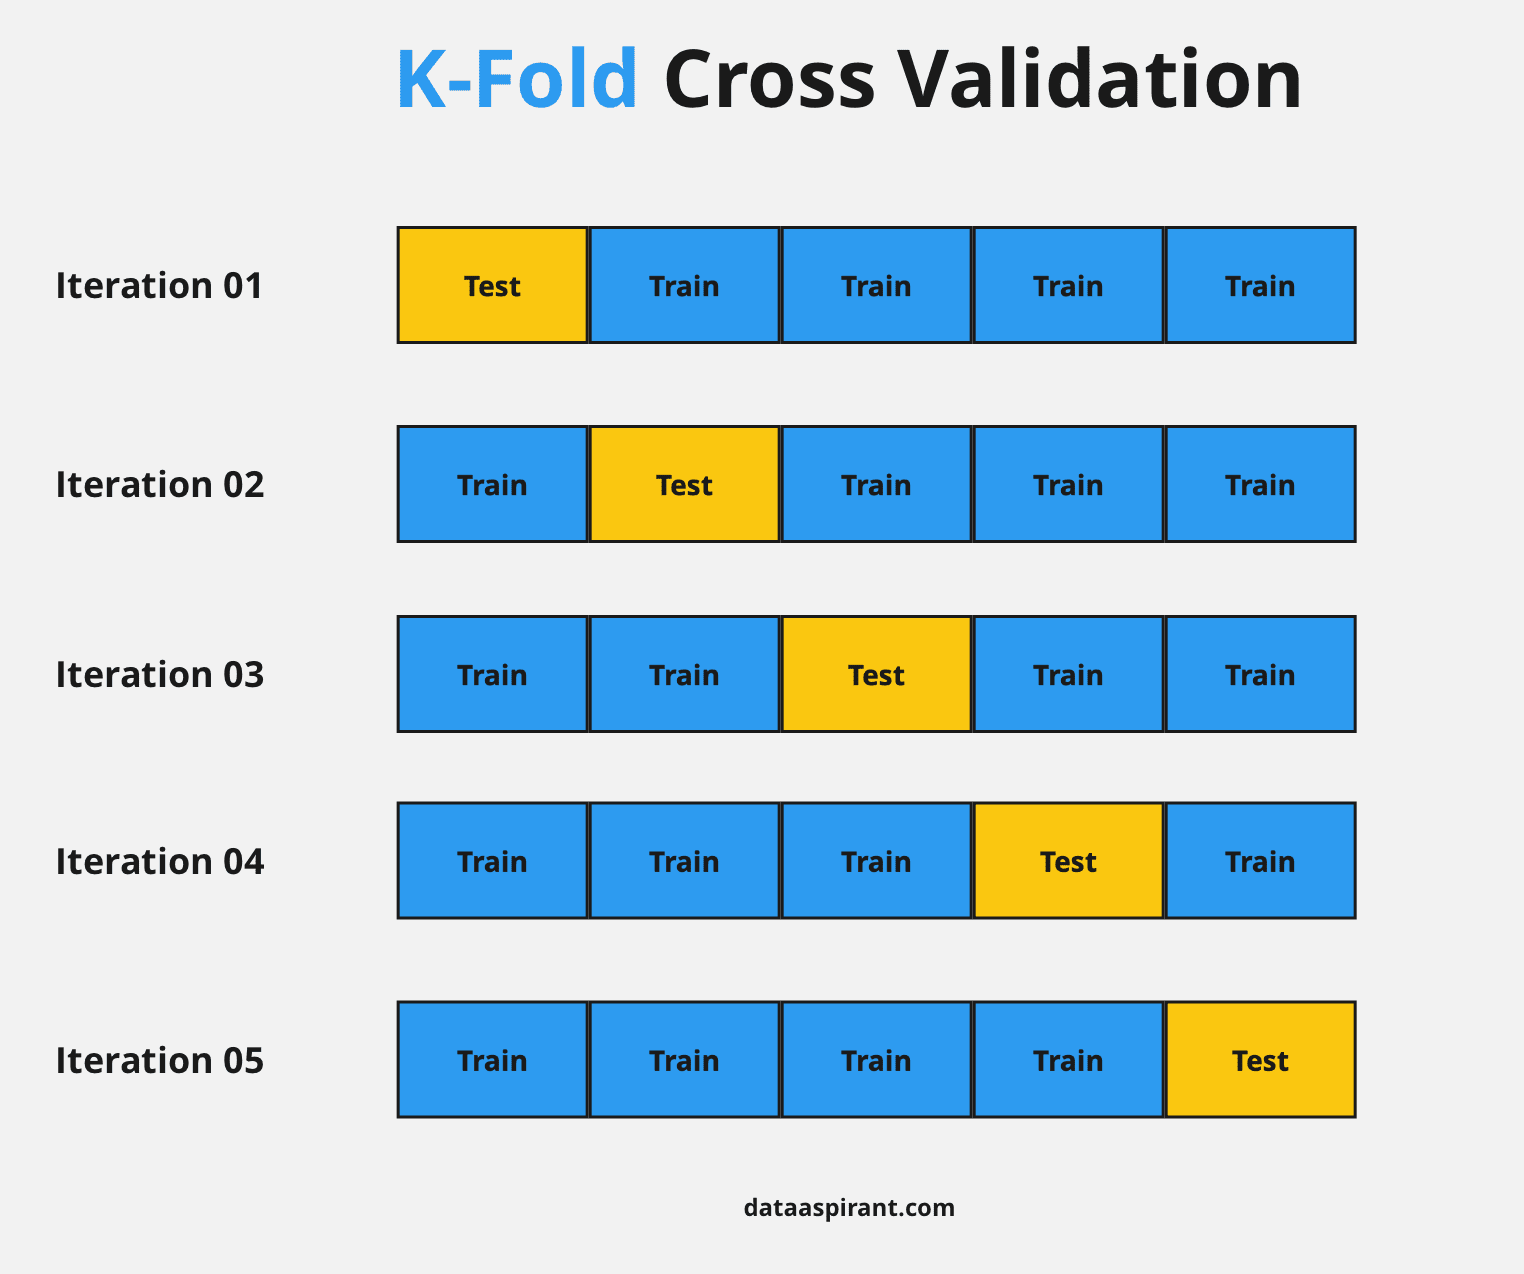

In [83]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

In [84]:
model = KNeighborsRegressor()

In [118]:
len(X_train), len(X_train) // 5

(5757, 1151)

In [119]:
for train_ind, test_ind in kf.split(X_train):
  print('train:', len(train_ind), 'test:', len(test_ind))
  model.fit(X_train[train_ind], y_train.values[train_ind])
  y_pred = model.predict(X_train[test_ind])
  print_metrics(y_pred, y_train.values[test_ind])
  print('--------------------------------------------------')

train: 4605 test: 1152
R^2: -1.1316476853828288
MSE: 2.0774565972222225
--------------------------------------------------
train: 4605 test: 1152
R^2: -1.1706359788309624
MSE: 2.004644097222222
--------------------------------------------------
train: 4606 test: 1151
R^2: -1.1282096188474489
MSE: 2.0838227628149437
--------------------------------------------------
train: 4606 test: 1151
R^2: -0.8456993305522724
MSE: 1.9353344917463073
--------------------------------------------------
train: 4606 test: 1151
R^2: -0.8978059632358033
MSE: 1.8531190269331017
--------------------------------------------------


# Часть 2

# Tensorflow

In [121]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [123]:
X = np.random.rand(1000, 20)
y = np.random.randint(2, size=(1000, 1))
y[:5]

array([[0],
       [0],
       [0],
       [1],
       [1]])

In [124]:
model = Sequential([
    Dense(64, input_dim=20, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X, y, epochs=10, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5165 - loss: 0.6975
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5106 - loss: 0.6930
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5247 - loss: 0.6925
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5268 - loss: 0.6905
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5454 - loss: 0.6879
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5668 - loss: 0.6848
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5651 - loss: 0.6820
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5434 - loss: 0.6873
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5696 - loss: 0.6842
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5754 - loss: 0.6814


In [126]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,229 (16.52 KB)

 Trainable params: 1,409 (5.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,820 (11.02 KB)

In [125]:
loss, accuracy = model.evaluate(X, y)

print(f'Loss: {loss}, Accuracy: {accuracy}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5840 - loss: 0.6761
Loss: 0.6785581707954407, Accuracy: 0.578000009059906


Задание 1:
1. Изучите и выполните пример 1 на Jupyter Notebook или Colab..
2. Поэкспериментируйте с новыми параметрами:

• Перый слой содержит 128 нейронов с активацией tanh

• Второй слой – один нейрон с активацией softmax

• Изменить оптимизатор на rmsprop.

In [171]:
model = Sequential([
    Dense(128, input_dim=20, activation='tanh'), # 128 tanh
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.fit(X, y, epochs=10, batch_size=32)

loss, accuracy = model.evaluate(X, y)

print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5011 - loss: 0.7010
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5208 - loss: 0.6971
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5246 - loss: 0.6942
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5258 - loss: 0.6923
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5663 - loss: 0.6869
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5404 - loss: 0.6906
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5315 - loss: 0.6923
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5540 - loss: 0.6874
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5661 - loss: 0.6865
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5457 - loss: 0.6828
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5706 - loss: 0.6854
Loss: 0.6877151131629944, Accuracy: 0.5540000200271606


# Pytorch

In [127]:
import torch
from torch import nn

In [192]:
class ModelTorch(nn.Module):
  def __init__(self, input_shape=20, hidden_units=60, output_shape=1):
    super().__init__()
    self.layer1 = nn.Linear(input_shape, hidden_units)
    self.layer2 = nn.Linear(hidden_units, output_shape)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.sigmoid(x)
    x = self.layer2(x)

    return x

In [193]:
model_t = ModelTorch()

In [194]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_t.parameters(), lr=1e-3)

In [195]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [196]:
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train).float()
y_test_tensor = torch.from_numpy(y_test).float()

In [197]:
epochs = 10

for epoch in range(epochs):
    model_t.train()

    y_pred = model_t(X_train_tensor)

    loss = loss_fn(y_pred, y_train_tensor)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_t.eval()

    with torch.inference_mode():
        test_pred = model_t(X_test_tensor)

        test_loss = loss_fn(test_pred, y_test_tensor)

    print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.7227552533149719 | Test loss: 0.7191480398178101
Epoch: 1 | Train loss: 0.7183709740638733 | Test loss: 0.7150733470916748
Epoch: 2 | Train loss: 0.7143404483795166 | Test loss: 0.7113552689552307
Epoch: 3 | Train loss: 0.7106683254241943 | Test loss: 0.7079966068267822
Epoch: 4 | Train loss: 0.7073550224304199 | Test loss: 0.705004870891571
Epoch: 5 | Train loss: 0.7044041156768799 | Test loss: 0.702381432056427
Epoch: 6 | Train loss: 0.7018219828605652 | Test loss: 0.7001310586929321
Epoch: 7 | Train loss: 0.69960618019104 | Test loss: 0.6982439160346985
Epoch: 8 | Train loss: 0.6977453827857971 | Test loss: 0.6967036724090576
Epoch: 9 | Train loss: 0.6962223649024963 | Test loss: 0.6954872608184814


# 2 Задание

In [225]:
from tensorflow.keras.datasets import mnist

(train_img, train_labels), (test_img, test_labels) = mnist.load_data()

In [226]:
train_img.shape, test_img.shape

((60000, 28, 28), (10000, 28, 28))

In [227]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

**Задание 2:** Изучите и выполните пример 2 на Jupyter Notebook или
Colab. Измените параметры:

• размер мини-выборки (batch_size) на 64

• число эпох (epochs) на 20

Посмотрите новый результат точности на контрольном наборе и
сравните с результатом примера 2.

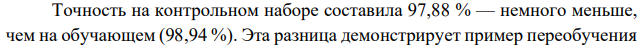

Точность на FNN (Fully connected Neural Network, полносвязная нейронная сеть) из тетради составила 97.88, 98.94. Я добавлю свертки и моя задача будет дойти минимум до 99.0

# Tensorflow, Keras

In [228]:
from keras.layers import Flatten, MaxPool2D, Conv2D

In [229]:
train_img = np.expand_dims(train_img, axis=-1) / 255
test_img = np.expand_dims(test_img, axis=-1) / 255

In [231]:
# np.expand_dims добавил размерность как unsqueeze в торче
train_img.shape

(60000, 28, 28, 1)

In [232]:
model_mnist = Sequential([
    Conv2D(32, (3, 3), activation='relu'),
    MaxPool2D((4, 4)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

model_mnist.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_mnist.fit(train_img, train_labels, epochs=10, batch_size=128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 79ms/step - accuracy: 0.8560 - loss: 0.5046
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.9731 - loss: 0.0909
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9814 - loss: 0.0611
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - accuracy: 0.9860 - loss: 0.0449
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9897 - loss: 0.0353
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.9921 - loss: 0.0274
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9924 - loss: 0.0233
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.9936 - loss: 0.0210
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.9956 - loss: 0.0153
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - accuracy: 0.9965 - loss: 0.0126


In [234]:
test_loss, test_acc = model_mnist.evaluate(test_img, test_labels)

print(f"test_acc: {test_acc}\ntest_loss: {test_loss}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9880 - loss: 0.0410
test_acc: 0.9901000261306763
test_loss: 0.03318687528371811


# Pytorch

In [253]:
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

In [256]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [255]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [258]:
next(iter(train_dataloader))[1]

tensor([1, 4, 1, 3, 0, 6, 8, 0, 1, 6, 6, 4, 5, 5, 7, 9, 3, 6, 3, 0, 0, 2, 3, 9,
        3, 6, 9, 6, 1, 2, 6, 7, 9, 0, 7, 6, 4, 7, 0, 4, 9, 3, 8, 7, 0, 7, 5, 2,
        4, 7, 6, 7, 4, 4, 8, 7, 1, 1, 3, 5, 8, 4, 7, 2, 0, 8, 3, 7, 5, 5, 0, 5,
        9, 8, 6, 7, 0, 4, 9, 1, 7, 1, 3, 0, 8, 5, 3, 1, 7, 8, 0, 8, 1, 4, 1, 6,
        7, 3, 5, 4, 3, 4, 4, 3, 1, 5, 0, 6, 2, 5, 8, 4, 5, 2, 8, 8, 3, 6, 0, 8,
        6, 3, 9, 1, 3, 8, 7, 2])

In [290]:
class ModelTorchMnist(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU())
    self.fnn = nn.Sequential(
        nn.Flatten(),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units * 28 * 28, out_features=output_shape),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.conv_block(x)
    x = self.fnn(x)

    return x

In [291]:
model_torch_mnist = ModelTorchMnist(input_shape=1,
                                    hidden_units=32,
                                    output_shape=10)

In [292]:
NUM_EPOCHS = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_torch_mnist.parameters(), lr=0.001)

In [293]:
img_batch, label_batch = next(iter(train_dataloader))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model_torch_mnist.eval()
with torch.inference_mode():
  pred = model_torch_mnist(img_single)

# Random weights
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 1, 28, 28])

Output logits:
tensor([[0.1071, 0.0691, 0.1473, 0.0714, 0.0848, 0.1290, 0.0957, 0.1023, 0.0822,
         0.1111]])

Output prediction probabilities:
tensor([[0.1007, 0.0969, 0.1048, 0.0972, 0.0985, 0.1029, 0.0995, 0.1002, 0.0982,
         0.1011]])

Output prediction label:
tensor([2])

Actual label:
6


In [295]:
from tqdm.auto import tqdm

for epoch in tqdm(range(NUM_EPOCHS)):
  model_torch_mnist.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X, y

    y_pred = model_torch_mnist(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  # Тест

  model_torch_mnist.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
      X, y = X, y

      test_pred_logits = model_torch_mnist(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

  train_loss = train_loss / len(train_dataloader)
  train_acc = train_acc / len(train_dataloader)

  test_loss = test_loss / len(test_dataloader)
  test_acc = test_acc / len(test_dataloader)

  print(
      f"Epoch: {epoch + 1} | "
      f"train_loss: {train_loss:.4f} | "
      f"train_acc: {train_acc:.4f} | "
      f"test_loss: {test_loss:.4f} | "
      f"test_acc: {test_acc:.4f}"
  )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0217 | train_acc: 0.4300 | test_loss: 1.7802 | test_acc: 0.6796
Epoch: 2 | train_loss: 1.5244 | train_acc: 0.9407 | test_loss: 1.4919 | test_acc: 0.9716
Epoch: 3 | train_loss: 1.4897 | train_acc: 0.9742 | test_loss: 1.4867 | test_acc: 0.9762
Epoch: 4 | train_loss: 1.4826 | train_acc: 0.9809 | test_loss: 1.4843 | test_acc: 0.9785
Epoch: 5 | train_loss: 1.4787 | train_acc: 0.9845 | test_loss: 1.4837 | test_acc: 0.9781
Epoch: 6 | train_loss: 1.4762 | train_acc: 0.9868 | test_loss: 1.4849 | test_acc: 0.9778
Epoch: 7 | train_loss: 1.4743 | train_acc: 0.9882 | test_loss: 1.4819 | test_acc: 0.9807
Epoch: 8 | train_loss: 1.4728 | train_acc: 0.9898 | test_loss: 1.4819 | test_acc: 0.9804
Epoch: 9 | train_loss: 1.4713 | train_acc: 0.9910 | test_loss: 1.4821 | test_acc: 0.9802
Epoch: 10 | train_loss: 1.4703 | train_acc: 0.9920 | test_loss: 1.4815 | test_acc: 0.9806


**Tensorflow, Keras** 2 : 0 **PyTorch**